In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt





<h1 style="text-align: center'; font-size: 45px">Eigenfaces</h1>


<h1 style="text-align: center'; font-size: 35px">Abstract</h1>

An eigenface is the name given to a set of eigenvectors when used in the computer vision problem of human face recognition. The approach of using eigenfaces for recognition was developed by Sirovich and Kirby (1987) and used by Matthew Turk and Alex Pentland in face classification. We will use the correlation matrix to find the eigenvalues and eigenvectors and then find the eigenfaces. This produces dimension reduction by allowing the smaller set of basis images to represent the original training images. Classification can be achieved by comparing how faces are represented by the basis set.

# 1.Reading the dataset

The dataset that is used is the cropped version of **The Extended Yale Face Database B**. The database contains 2470 frontal-face images with size 192×168 over 38 subjects and 65 images per subject. The images were captured under different lighting conditions and various facial expressions. This dataset is decent for the task of finding the eigenfaces, because there is no background and hair captured, but the allignment of the faces is not perfect, as we will see later when we compute the eigenfaces.

In [3]:
IMAGE_DIR = 'CroppedYale'
DEFAULT_SIZE = [192, 168] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open(os.path.join(dir_path, image_name))
            # resize to given size (if given)
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir)
    return [images,images_names]

For the *first* part of the task, we are going to use the first 36 people, 2340 images, from which we will derive the eigenfaces. The other 2 people, 130 images, we will use for *testing purposes*.

In [4]:
X, y = read_images()

people = X[:2340]
test_people = X[2340:]

# 2. Assembling the matrix

We reshape every image to a vector. Images of size 192x168 pixels will become vector with length of 32256. Then, we add each vector to the matrix. Every row of the matrix will be an image.

In [5]:
A = np.empty((0, people[0].size ), dtype=people[0].dtype)
for row in people:
    A = np.vstack((A, np.asarray(row).reshape(1, -1)))


Later we will display images, but need to reshape them first. I found it convenient to write separate function and save some time.

In [6]:
def plot_image(image):
    plt.imshow(np.reshape(image, (168, 192)), cmap="gray")
    plt.axis("off")
    plt.show()

# 3. Finding the mean face

We find the mean or average face (vector) by the formula: $$ \mu = \frac{1}{n}\sum _{i=1} ^n x_{i}$$

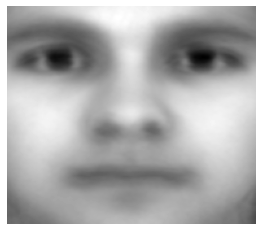

In [7]:
mean_vector = np.mean(A, axis=0)
plot_image(mean_vector)

Next, we subtract the *mean face* from every face in the matrix. We do that in order to find what differentiates one image from another, excluding the most common features(mouth, nose, eyes, etc.).

In [8]:
A = (A - mean_vector).T

# 4. Computing the Singular Value Decomposition (SVD)

Before stepping into the SVD, we will first see what are eigenvectors and eigenvalues.
In linear algebra, an eigenvector of a linear transformation is a nonzero vector that changes at most by a scalar factor when that linear transformation is applied to it. The corresponding eigenvalue, often denoted by $\lambda$, is the factor by which the eigenvector is scaled. More formally, if $ T $ is a linear transformation from a vector space V over a field F into itself and v is a vector in V that is not the zero vector, then v is an eigenvector of $ T $ if $ {T}(v) $ is a scalar multiple of $ v $. This condition can be written as the equation

$$ {T}(v) = \lambda v $$
where $ \lambda  $ is a scalar in the field $ F $, known as the eigenvalue, characteristic value, or characteristic root associated with the eigenvector $ v $.

If the vector space $ V $ is finite-dimensional, then the linear transformation $ T $ can be represented as a square matrix $ A $, and the vector $ v $ by a column vector, rendering the above mapping as a matrix multiplication on the left hand side and a scaling of the column vector on the right hand side in the equation

$$ Av = \lambda v $$
There is a correspondence between n by n square matrices and linear transformations from an n-dimensional vector space to itself. For this reason, it is equivalent to define eigenvalues and eigenvectors using either the language of matrices or the language of linear transformations.

All the eigenvectors are orthogonal (perpendicular). This is important because we can express the data in term of eigenvectors, instead of expressing them in the original space.

**SVD** and **PCA** are the most popular ways to find the eigenfaces of a image dataset. The difference between **SVD** and **PCA** is that **SVD** gives you the whole nine-yard of diagonalizing a matrix into special matrices that are easy to manipulate and to analyze. It lays down the foundation to untangle data into independent components. PCA skips less significant components.

In linear algebra, the singular value decomposition **SVD** is a factorization of a real or complex matrix that generalizes the *eigendecomposition* of a square normal matrix to any $m x n$ matrix via an extension of the *polar decomposition*. In contrast to the *Eigenvalue decomposition*, the **SVD** of a matrix always exists.

$$ A = U \sum V^{T} $$

The *standard* way to compute **SVD** is to compute the covariance *$n$ x $n$* matrix $AA^{T}$. That way the eigenvectors of this matrix will be the eigenfaces, containing in the $U$ matrix, but that is very computationally expensive. The *economy* way to compute **SVD** is to compute the correlation *$m$x$m$* matrix $A^{T}A$, which presents the relation between each image. The eigenvectors of this matrix will give the matrix $V^{T}$ from the formula. Each column of the $V^{T}$ matrix contains coefficients, corresponding to the eigenfaces and show how much of each eigenface is consisted in every image of the training data. 

The correlation matrix contains the inner products of people's faces. When a value in the matrix is large, that means that the two images are simmilar, and if the value is small, that means that the images are very different and nearly orthogonal.

In order to derive the eigenfaces and eigenvalues of $A^{T}A$ matrix, we need to do some transformations in the equation. Before we do transformations, we should know that:

$$ UU^{T} = U^{T}U = I $$
$$ VV^{T} = V^{T}V = I $$
<p style="text-align:center">where $I$ is the Identity matrix and the $U$ and $V^{T}$ matrices are orthogonal.</p>

The $\sum$ matrix is hierarchically ordered diagonal matrix and contains the eigenvalues of the correlation matrix, that show how much variance is captured by the corresponding eigenfaces. In oder words, it shows how important every vector is. Given the fact that $\sum$ is hierarchically ordered, the first eigenvector is more important than the second and so on($\sigma_{1}\geq\sigma_{2}\geq\sigma_{3}...\sigma_{k}$). The square root of every value in the $\sum$ matrix will give the singular values we need.

The matrix $A^{T}A$ can be represented by the formula $A = U\sum V^{T}$ as:

$$ A^{T}A = V\sum^{T} U^{T}U\sum V^{T} $$
$$ A^{T}A = V\sum^{T}\sum V^{T} $$
$$A^{T}AV = V\sum^{2}V^{T}V$$
$$A^{T}AV = \sum^{2}V$$ 

This final equation looks like the eigenequation, from which we can derive the eigenvalues and eigenvectors.

In [9]:
cor_mat = (A.T).dot(A)

In [10]:
eigvals, eigvects = np.linalg.eig(cor_mat)

In [11]:
sigma = np.sqrt(eigvals)
sigma = sigma * np.identity(len(sigma))

We got the $V^{T}$ and $\sum$ matrix, but now we want to find the eigenfaces or the $U$ matrix. We can do that by this transformation of the equation:

$$ A = U\sum V^{T}$$
$$ AV = U\sum $$
Since we know $A$, $\sum$ and $V^{T}$, we can reduce the equation to $a @ x = b$, where $a$ is $\sum$, $b$ is $AV$ and $x$ is the $U$ matrix we are looking for.

In [12]:
AV = A.dot(eigvects)

In [13]:
AV.shape

(32256, 2340)

In [14]:
eigfaces = np.linalg.lstsq(sigma, AV.T, rcond=None)[0].T

In [15]:
eigfaces.shape, sigma.shape, eigvects.shape

((32256, 2340), (2340, 2340), (2340, 2340))

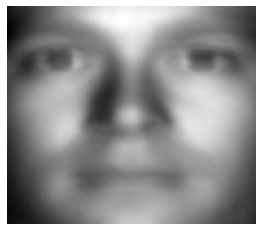

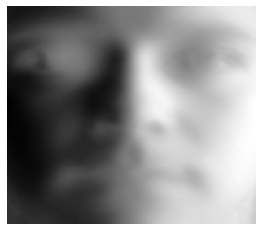

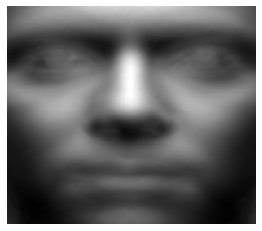

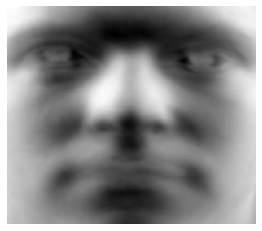

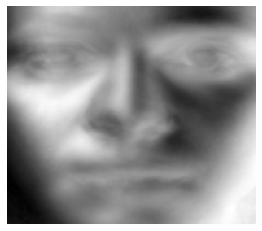

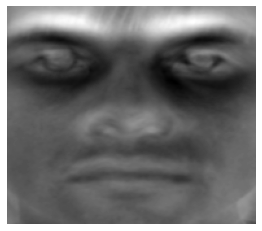

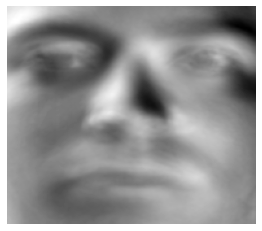

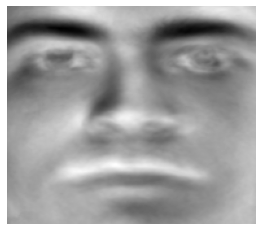

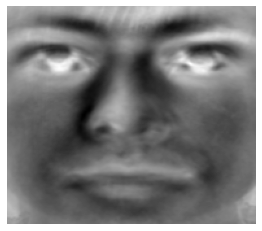

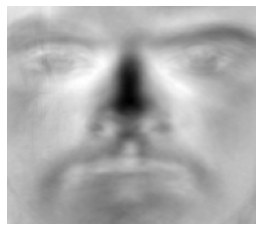

In [16]:
for i in range(10):
    plot_image(eigfaces[:, i])

We can compare the results to the numpy funcion for **SVD** *np.linalg.svd()*

In [18]:
U, S, VT = np.linalg.svd(A, full_matrices=0)

In [19]:
U.shape, S.shape, VT.shape

((32256, 2340), (2340,), (2340, 2340))

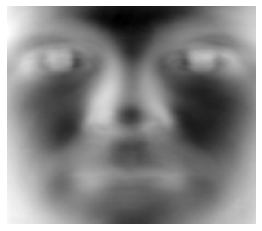

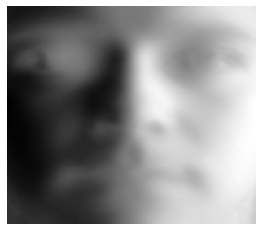

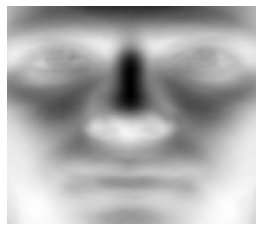

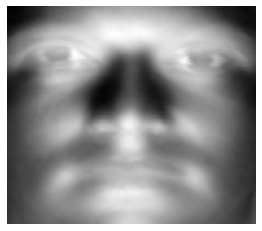

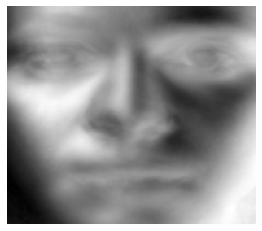

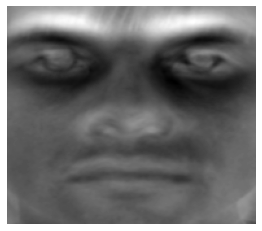

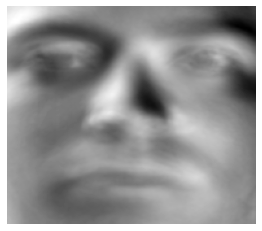

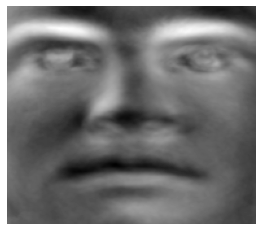

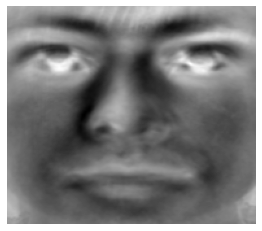

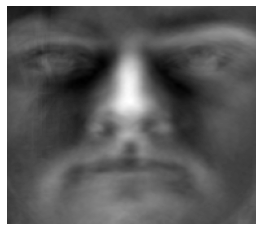

In [20]:
for i in range(10):
    plot_image(U[:, i])

As you can see, some of the numpy eigenfaces are different from our self-made. However, the most important thing is that this will not affect the reconstruction process. In fact, the images, reconstructed both from our and numpy eigenfaces will be the same.

# 5.Reconstructing image

Now, since we have everything, we are going to project an unknown image from test_people dataset. We will project the image by the formula $B = UU^{T}A$, where $A$ is the unknown image and $B$ is the projected on the eigenfaces image $A$.

In [21]:
mat2 = np.empty((0, test_people[0].size), dtype=test_people[0].dtype)
for row in test_people:
    mat2 = np.vstack((mat2, np.asarray(row).reshape(1, -1)))


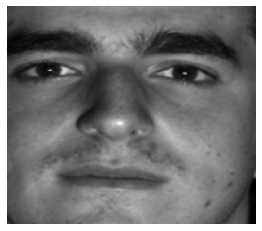

In [22]:
plot_image(mat2[101])

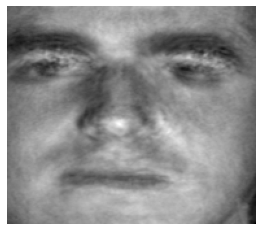

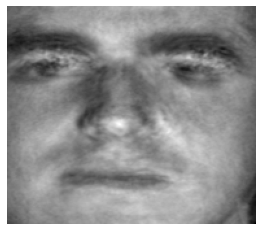

In [23]:
test_image = mat2[101]
r_list = [700]
for r in r_list:
    recon_face = (U[:, :r].dot(U[:, :r].T)).dot(test_image)
    plot_image(recon_face)
    r_face = (eigfaces[:, :r].dot(eigfaces[:, :r].T)).dot(test_image)
    plot_image(r_face)

As we see, there is no difference between our eigenfaces and the numpy eigenfaces.

Now, we can find the weights or the coefficients, which respond to every eigenface. Doing this, we can store only the coefficients of the eigenfaces which construct the projected image insted of the full image. We will store as much coefficients as the number of eigenfaces we want to use in reconstructing the image. This is the so called *dimensionality reduction*. 

In order to choose the number of eigenfaces that will represent the original image, we will use the formula $\frac{\sum_{i}^{k}}{\sum_{j}^{m}}$, where $k$ is the number of eigenfaces that we want to use and $m$ is all the eigenfaces. The result of this formula will give the percentage of variance that will be capture by the number of eigenfaces we chose. The number of eigenfaces that we choose to reconstruct the image will be the number of data that we will store.


In [24]:
s = sum(sigma)[:700]
result = sum(s) / sum(sum(sigma))
print(result)

0.8197895071264902


As we see, the percentage of variance that will be captured by 700 eigenfaces is about 82%. If we want to capture more variance, we can increase the number of eigenfaces.

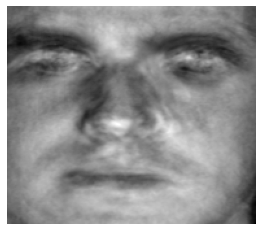

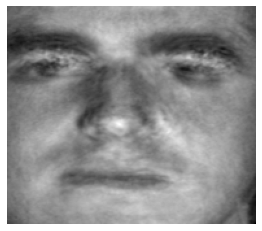

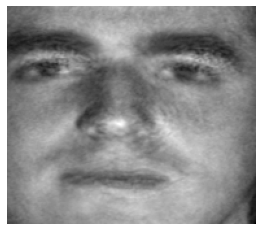

In [25]:
nums = [400, 700, 1200]
for num in nums:
    w = np.linalg.lstsq(a = eigfaces[:, :num], b = test_image - mean_vector, rcond=None)[0]
    face = w @ eigfaces[:, :num].T + mean_vector
    plot_image(face)

As we can see, as the number of eigenfaces increases, the image reconstruction gets better. But we should keep in mind that we do not want to store too much data, because the dimensionality reduction and storing less data is what we aim for.

# 6.Conclusion

We successfully coped with the task to reduce dimensionality. First, we found the mean face, which was subtracted from all images of the dataset in order to find what constructs an image except the basic things(nose, mouth, eyes, etc.). The, we found the SVD of the dataset, which gave us 3 matrices - $U$, $\sum$ and $V^{T}$ - the left eigenvectors(eigenfaces), the singular values $\sigma$ and the right eigenvectors. Then, we did reconstruction of an image with 700 of the eigenfaces which caputered nearly 82 percent of the variance. The set of eigenfaces that we obtained can be used in image classification, however, the dataset that they are obtained from is far from perfect for this task.

# 7. Refferences

 - https://en.wikipedia.org/wiki/Eigenface#:~:text=An%20eigenface%20
 - https://www.youtube.com/watch?v=nbBvuuNVfco&ab_channel=SteveBrunton
 - https://www.youtube.com/watch?v=cOUTpqlX-Xs&ab_channel=MITOpenCourseWare
 - https://www.youtube.com/watch?v=8BTv-KZ2Bh8&t=1s&ab_channel=AMATH301
 - https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm
 - https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491
 - https://en.wikipedia.org/wiki/Singular_value_decomposition#:~:text=In%20linear%20algebra%2C%20the%20singular,of%20a%20matrix%20always%20exists.
 - https://www.youtube.com/watch?v=WmDnaoY2Ivs&ab_channel=SteveBrunton